# Data Assimialation for the RAMP model using ABC

**Version 2. Builds on tests etc. created in [version 1](./ramp_da1.ipynb) to create comprehensive DA workflow**

Experiments with whether data assimilation, using ABC, can be used to optimise the model at runtime. 

## Background / motivation

Large uncertaintees in pandemic models
 - who is infected? (uncertainty around testing v.s. real prevalence)
 - when transmission occurs (symptoms / tests play out after the event)
 - interactions (as drivers of transmission) and other behavioural assumptions
 - others?

Parameters evolve
 - new variants influence transmission risk
 - state (etc) interventions influence behaviour
 - human response to interventions changes over time

Difficult to understand true picture of disease spread under these conditions

Opportunity for DA to reduce uncertainties and deal with changes in parameter values

## Approach

 - Use the RAMP model (OpenCL version) to simulate disease spread

 - Feed daily data on cases at MSOA level.

 - Identify key parameters that should be varied (e.g. behavioural) as the population evolves

## Case study

 - Focus on one area so that specific local policies can be properly modelled. Leeds (Council may be interested) or Devon? (as it works there anyway). Choose Devon initially.

 - Present work as as a proof of concept, i.e. a discussion about what DA can offer these types of models and a case study. 

 - Need to use a relatively simple model (with a simplified state vector) as identifiability will be a big problem. At this stage just focus on varying global parameters

## Data & Methods

Model

 - Very rich representation of individuals. Need to choose a few key (non-individual-level) variables:
   -  proportion of time spent spent doing different activities:
     - shopping, work, schooling (primary & secondary)
   - location hazard multipliers (e.g. vary infectiosness of (types of) places)
   - individual hazard multipliers (e.g. vary infectiosness of disease statuses)
   - (_details on these below, some work has already been done to calibrate them using ABC, e.g. see [abc-2.ipynb](abc-2.ipynb) and [abc-1.ipynb](abc-1.ipynb)).

Data

 - Case data most useful? Available at MSOA
 - Can be downloaded from https://coronavirus.data.gov.uk/details/download 
 - APIs available, e.g.: MSOA case data for Leeds: https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&areaCode=E08000035&metric=newCasesBySpecimenDateRollingSum&metric=newCasesBySpecimenDateRollingRate&format=csv 

Methods

 - Will assimilating for global variables work? Can you do it without updating the individuals' variables?
 - Start with flat priors rather than a calibrated model. Alternative would be to use initial prior estimates of the paramters that were generated through calibration (e.g. see the bottom of [abc-2.ipynb](abc-2.ipynb)) but more realistic to assume that at the start of a pandemic we don't know what optimised values for these parameters are.
 
## ToDo

[ ] needs doing, [?] Maybe needs doing, [-] in progress, [x] done

 1. [X] Read discussion about seeding on slack and decide how to seed and on which day to start the simulation (good case data only available from April 2020.
         - Hadrian is re-doing the seeding; can use the data that he is creating (from the ONS infection survey?)
         - [X] Wait for an update so I understand what the new seeding data are.
         - [X] Work out how these are integrated into the model.

 1. [?] Re-run abc-2.ipynb including presymptomatic and symptomatic multipliers so we have a rough idea about their prior distributions. (May not need to now using flat priors, although there could be value in re-running it using the new code as Fiona has made some changes).
 
 1. [X] Get up-to-date case data by MSOA
 
 1. [X] Implement simple OpenCL model that can step an arbitrary number of times and continue where it left off
 
 1. [X] Get information from this model (while running)
 
 1. [X] Compare model to MSOA case data
   
   1. [ ] Distance function has been implemented, but this needs improving (see notes from discussion with Rory & Hadrian)
 
 1. [X] Test altering the state of this model (while running) -> change a parameter value (disease status to show big increase after N days compared to the baseline?
 
 1. [ ] Use ABC to find the optimal parameters to have given us the observations
 
## Questions / Problems

 - [X] Read paper on the ABC SMC method ("[Simulation-based model selection for dynamical systems in systems and population biology](https://academic.oup.com/bioinformatics/article/26/1/104/182571)")
 
 - [ ] Over longer model runs, how to prevent the parameters from becomming stuck, as the volumne of historical data overwhealm new observations. E.g. ABC will calibrate the model, but wont allow for dynamic parameter updating because the previous x hundred days of data overwhealm any new changes. (Common problem for Bayesian updating?).
 
 - See if anything similar
   - [ ] E.g. Fergusson model used PF for calibration?

## Resources 

 - Paper: [Simulation-based model selection for dynamical systems in systems and population biology](https://academic.oup.com/bioinformatics/article/26/1/104/182571) - uses ABM SMC to do model and parameter selection


## Notes about the existing calibration of the variables

The individual hazards and location hazards were experimented with in [abc-1.ipynb](abc-1.ipynb) and [abc-2.ipynb](abc-2.ipynb) respectively.  Summary of best estimates (priors):

**Individual hazards** 

 - Asymptomatic multiplier (`asymptomatic`)
 
  - This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). 
  
 - Presymptomatic and symptomatic multipliers (`presymptomatic` and `symptomatic`)
  - Uniform between 0 and 1.

**Location hazards:

These are multipliers associated with locations (i.e. make some locations contribute more to the disease risk than others).

 - Home
  - Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0.
 - Retail:
  - Uniform between 0 and 1.
 - PrimarySchool: 1.0
  - Uniform between 0 and 1.
 - SecondarySchool: 1.0
  - Uniform between 0 and 1.
 - Work: 1.0
  - Uniform between 0 and 1.


## Import modules

See [abc-1.ipynb](abc-1.ipynb) for notes about installing these libraries

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

# For easier plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# These allow you to plot in a notebook -- may first need to install the jupyter lab plotly extension:
# jupyter labextension install jupyterlab-plotly@4.8.2
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

# RAMP model
from microsim.initialisation_cache import InitialisationCache
#from microsim.opencl.ramp.run import run_headless
#from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
#from microsim.opencl.ramp.snapshot import Snapshot
#from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
#from microsim.opencl.ramp.simulator import Simulator
#from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys
sys.path.append('..')
from opencl_runner import OpenCLWrapper # Some additional functions to simplify running the OpenCL model

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Read case data and spatial data

GIS Data

In [2]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

gis_data_dir = ("../../devon_data")
#osm_buildings = load_osm_shapefile(gis_data_dir)
devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)
devon_msoa_shapes = devon_msoa_shapes.set_index('Code', drop=True, verify_integrity=True)

Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


Cases data. These were prepared by Hadrien and made available on the RAMP blob storage (see the observation data [README](./observation_data/README.md)).

In [8]:
cases_msoa = pd.read_csv(os.path.join("observation_data", "england_initial_cases_MSOAs.csv")).set_index('MSOA11CD', drop=True, verify_integrity=True)

# Merge them to the GIS data for convenience
cases_msoa = cases_msoa.join(other = devon_msoa_shapes, how="inner")  # Joins on the indices (both indices are MSOA code)
assert len(cases_msoa) == len(devon_msoa_shapes)  # Check we don't use any areas in the join

# For some reason we lose the index name when joining
cases_msoa.index.name = "MSOA11CD"

# Melt so that cases on each day (D0, D1, ... D404) become a value in a new row
# (Also need to convert the index (area code) to a column)
cases_msoa_melt = pd.melt(cases_msoa.reset_index(), id_vars='MSOA11CD', 
                          value_vars=[ "D"+str(i) for i in range(405) ]).rename(columns={'value':'cases'})
cases_msoa_melt = cases_msoa_melt.set_index('MSOA11CD', drop=True) # Keep the index as the MSOA
cases_msoa_melt['day'] = cases_msoa_melt['variable'].apply(lambda day: int(day[1:])) # Strip off the initial 'D' to get the day number

cases_msoa

           D0  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  D395  D396  D397  \
MSOA11CD                                           ...                     
E02000001   0   0   0   0   0   0   0   0   0   0  ...     0     0     0   
E02000002   0   0   0   0   0   0   0   0   0   0  ...    42    52    50   
E02000003   0   0   0   0   0   0   0   0   0   0  ...     0     0     0   
E02000004   0   0   0   0   0   0   0   0   0   0  ...    21     0     0   
E02000005   0   0   0   0   0   0   0   0   0   0  ...    42     0     0   

           D398  D399  D400  D401  D402  D403  D404  
MSOA11CD                                             
E02000001     0     0     0     0     0    27    26  
E02000002    47    45    43    42    40     0     0  
E02000003     0     0     0     0     0     0     0  
E02000004     0     0     0     0     0     0     0  
E02000005     0     0     0     0     0    27    26  

[5 rows x 405 columns]


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,objectid,msoa11nm,msoa11nmw,st_area(sh,st_length(,geometry,Easting,Northing,Num,Desc
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02004129,0,0,0,0,0,0,0,0,0,0,...,4029,East Devon 001,East Devon 001,1.589055e+08,78853.452613,"POLYGON ((-3.05239 50.90821, -3.05130 50.90635...",319112.091,106067.255,6164,East Devon 001
E02004130,0,0,0,0,0,0,0,0,0,0,...,4030,East Devon 002,East Devon 002,5.595690e+06,16608.909124,"POLYGON ((-3.17191 50.81402, -3.17086 50.81375...",316418.665,100589.954,6232,East Devon 002
E02004131,0,0,0,0,0,0,0,0,0,0,...,4031,East Devon 003,East Devon 003,7.382371e+06,15049.731064,"POLYGON ((-3.20774 50.79940, -3.20636 50.79835...",315676.823,99850.503,6233,East Devon 003
E02004132,0,0,0,0,0,0,0,0,0,0,...,4032,East Devon 004,East Devon 004,1.104563e+08,63961.520903,"POLYGON ((-3.32158 50.85752, -3.31924 50.85695...",309179.725,99451.515,6228,East Devon 004
E02004133,0,0,0,0,0,0,0,0,0,0,...,4033,East Devon 005,East Devon 005,5.164724e+07,46310.010611,"POLYGON ((-2.99660 50.83564, -2.99693 50.83347...",330154.040,98658.412,6230,East Devon 005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02004231,0,0,0,0,0,0,0,0,0,0,...,4131,West Devon 003,West Devon 003,3.631116e+08,144265.307997,"POLYGON ((-3.85341 50.78179, -3.84621 50.78142...",267510.764,89195.616,6259,West Devon 003
E02004232,0,0,0,0,0,0,0,0,0,0,...,4132,West Devon 004,West Devon 004,2.699329e+08,126017.390843,"POLYGON ((-4.18597 50.75767, -4.17707 50.75329...",243289.074,83388.837,6256,West Devon 004
E02004233,0,0,0,0,0,0,0,0,0,0,...,4133,West Devon 005,West Devon 005,1.331482e+07,22485.720797,"POLYGON ((-4.13335 50.57835, -4.12845 50.56881...",248100.775,73943.230,6257,West Devon 005


Look at total daily cases

In [4]:
fig = px.line(cases_msoa_melt.groupby('day').sum(), y="cases", title="Total daily cases across study area",
              height=400, width=800)
fig.show()

Cases by MSOA

In [10]:
# More complicated example includes secondary axis for the total cases *and* shows how to have two plots at once
fig = make_subplots(specs=[[{"secondary_y": False}, {"secondary_y": True}]], rows=1, cols=2, 
                    subplot_titles=(f"Cases per MSOA", f"Cases per MSOA and total cases"))

# First chart. Just the total cases
total = cases_msoa_melt.groupby('day').sum()
fig.add_trace(
    go.Scatter(x=total.index, y=total.cases,
               mode="lines", line={'color': 'black'}, name="Total daily daily cases"),
    row=1, col= 1)

# Second chart. Total cases by MSOA and total cases on secondary axis (need a trace for each MSOA)
for msoa in cases_msoa_melt.index.unique():
    df = cases_msoa_melt.loc[msoa]
    fig.add_trace(
        go.Scatter(x=df.day, y=df.cases, mode="lines", name=f"{msoa}"),
        secondary_y = False, row=1, col= 2)

fig.add_trace(
    go.Scatter(x=total.index, y=total.cases,
               mode="lines", line={'color': 'black'}, name="Total daily daily cases"),
    secondary_y = True, row=1, col= 2)
#del total, df

fig.update_layout(title_text="Daily Cases") # Add figure title
fig.update_xaxes(title_text="Days") # Set x-axis title

# Set y-axes titles
fig.update_yaxes(title_text="Daily cases per MSOA", secondary_y=False)
fig.update_yaxes(title_text="Total daily cases", secondary_y=True)

fig.show()

(note the spike in cases in one MSOA, [E02004149](https://findthatpostcode.uk/areas/E02004149.html), called 'Pennsylvania & University')

Map the cases over time (doesn't work)

Function to plot disease status by MSOA for a given timestep and status (useful later)

In [11]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Setup Model

Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).

Open the (newly created?) snapshot

In [12]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

Read the data about the individuals and their locations that are used to create the model (these are stripped down and converted into arrays in the OpenCL model, and it can be useful to have access to the richer, raw data).

In [26]:
# (Code to read the cached individuals and locations do this is in main.py)
DATA_DIR = os.path.join("..", "..","devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                "few cells up that initialises the population")
    
individuals, activity_locations = cache.read_from_cache()

#print(f"Activity locations: {activity_locations}")
len(individuals)
len(activity_locations)
activity_locations
#individuals
individuals.columns

Index(['ID', 'area', '_hid', '_pid', 'pid_tus', 'pid_hse', 'Sex', 'age',
       'Age1', 'Origin', 'hhref', 'hhnssec5', 'pnssec5', 'pwkstat', 'psic2007',
       'punknown', 'phome', 'pworkhome', 'pwork', '_pschool', 'pshop',
       'pservices', 'pleisure', 'pescort', 'ptransport', 'pnothome',
       'phometot', 'pmwalk', 'pmcycle', 'pmprivate', 'pmpublic', 'pmunknown',
       'soc2010', 'sic1d07', 'sic2dlab', 'hhnssec', 'GenHelf', 'BMIvg6',
       'obese40', 'copd', 'bloodpressure', 'smoke', 'underlining', 'cvd',
       'diabetes', 'BMI_healthier', 'House_ID', 'pschool-primary',
       'pschool-secondary', 'Home_Venues', 'Home_Flows', 'Home_Risk',
       'Home_Duration', 'Retail_Venues', 'Retail_Flows', 'Retail_Risk',
       'Retail_Duration', 'PrimarySchool_Venues', 'PrimarySchool_Flows',
       'PrimarySchool_Risk', 'PrimarySchool_Duration',
       'SecondarySchool_Venues', 'SecondarySchool_Flows',
       'SecondarySchool_Risk', 'SecondarySchool_Duration', 'Work_Venues',
       'Work_

## Run RAMP Model using ABC to do DA

### General approach (old approach)

This approach wasn't tested. 

It assumed that RVs were number of asymptomatic and presymptomatic people per MSOA (so 107\*2 RVs in total). 

After each window new model states were drawn using the posterior of these RVs. 

Advantages:
 - It would deal with emerging clusters of diseases because it would be possible to seed more cases in highly infected areas  

Disadvangages:
 - Too many RVs, not enough data?
 - What about the other disease states? Would need some way to estimate number of exposed, symptomatic, etc. If these were included as additional RVs then impossible or unrealistic models might be created (e.g. where there are loads of symptomatic people but no asymptomatic)

### General Approach (current)

This is the approach currently taken. The RVs are the global parameters, so we do not draw new model states at the end of a DA window. Instead draw from the existing particles from the previous window (based on their weight).

#### First window 

Begin by using ABC to run the model for _w_ weeks (the size of the DA window), seeding as normal.

#### Remaining windows

Updating random variables:
 - Use the new `ArbitraryDistribution` class as a way to pass the posterior from the previous run in to the next ABC run as the prior. This will update the global parameters

Drawing new model states: 
 - ABC gives us a load ($N=100$?) of particles (model states) and associated weights.
 - The full model state of these particles can be stored by using the `summary_statistics` function.
 - Draw new model states from these old particles (probability of drawing is proportional to their weight) and continue running the models.

 
### Lit review notes

 - Two 'tracks' in flu prediction: (i) predict evolutionary change based on mutation; (ii) use data assimilation to generate real-time forecasts using DA ([Du et al(2017)](https://stm.sciencemag.org/content/9/413/eaan5325?intcmp=trendmd-stm)) (_that paper not so relevant becuse it models evolutionary change of the virus not disease spread itself_).
 - "Five studies used data assimilation to update forecasts with new surveillance data" ([Chretiew et al 2014](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094130)).
    - "Several studies coupled mechanistic models with methods to update parameter estimates and forecasts as new influenza-related surveillance data becomes available. Nsoesie et al. [11], [13] developed a simulation-optimization algorithm for their ABM, which iteratively proposes estimates of key epidemiological parameters, uses those estimates to simulate the future course of the epidemic, and compares observed surveillance data to forecasts to revise the parameter estimates. Ong et al. [25] and Shaman et al. [10], [16] used data assimilation techniques to incorporate influenza-related surveillance data into their compartmental models and update parameter estimates and forecasts."
 - [Lega and Brown (2016)](https://www.sciencedirect.com/science/article/pii/S1755436516300329) use data-driven method that is updated case data, but model is v. simple mathematical (basically a cumulative epidemiological curve)
 - [Osgood & Liu (2014)](https://ieeexplore.ieee.org/document/7019944) use a particle filter to update a compartmental (systems dynamics) transmission model. Validated using an agent-based ground truth model.
 - [XX](https://link.springer.com/article/10.1007%2Fs10696-014-9204-0) use a particle filter and a compartmental epidemic model to combine two datasets; one reliable but time delayed, one noisier but immediate.
   - Note: may be worth looking up: "we use a modified version of the out-of-sequence-measurement particle filter by [Orton and Marrs (2005)](https://ieeexplore.ieee.org/document/1468758/) to handle the delayed measurement data."
 - [Ong et al (2010)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0010036) use a stochastic model of disease dynamics, refitted to data using a particle filter.
 - [Shaman and Karspeck (2012)](https://www.pnas.org/content/109/50/20425) compare the problem to that of numerical weather prediction (_v. nice problem contextualisation_). Apply the 'ensemble adjustment Kalman filter (EAKF)' using weekly estimates from Google Flu Trends into a SIRS flu model. _No geography?_. Demonstrate advantage by showing what would happen to future predictions were there no DA. _Could use something similar_.
   - Extended to other cities in Nature Communications: [Sharman et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/24302074/)
   
 - [Tabataba et al. (2017)](https://doi.org/10.1109/ICDM.2017.145) use an ABM and 'smart beam particle filtering' to do DA on an ABM epidemic model. The state vector that is optimised contains global model parameters, not individual agent variables, so it is more like calibrating dynamically evolving parameters rather than updating model states.
 - [Niu et al (2014)](https://doi.org/10.1890/ES13-00273.1) DA is widely used in modelling infectious disease spread, but examples use aggregate (e.g. SEIR) models rather than ABMs.
 - [Pasetto et al, 2017](https://doi.org/10.1016/j.advwatres.2016.10.004) use an EnKF to a spatially-explicit community-based cholera model. Sequential parameter updating utperforms MCMC calibration.
 
TODO: 
  - look for relevant recent papers that cite these two:
    - [ ] https://scholar.google.co.uk/scholar?cites=15782818616140504172&as_sdt=2005&sciodt=0,5&hl=en
    - [ ] https://scholar.google.co.uk/scholar?cites=12970851448971814953&as_sdt=2005&sciodt=0,5&hl=en
  - read [Modelling the influence of human behaviour on the spread of infectious diseases: a review](https://doi.org/10.1098/rsif.2010.0142)

### Summary statistics and distance function

Model results are dealt with in two stages. The raw output is passed to `opencl_runner.OpenCLWrapper.summary_stats()`. This optional step allows us to store extra bits of information in the results dictionary. We store the model state so that models can be restarted. The output from `summary_stats` is then passed to `opencl_runner.OpenCLWrapper.distance()` which calculates the error by comparing the results to real observations.

### Constants

These are not touched by ABC. Include parameters that should not be optimised.

In [31]:
const_params_dict = {
    "current_risk_beta": 0.03, # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0,  # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}
# (Include all global parameters)
#const_params_dict = {
#    "current_risk_beta": 0.03, # Global risk parameter
#    "presymptomatic": 1.0, "symptomatic": 1.0, "asymptomatic": 0.25, # Individual hazard multipliers
#    "home": 1.0, "retail": 0.75, "primary_school": 0.75, "secondary_school": 0.9, "work": 0.05, # Location hazard multipliers 
#}

### Random variables and the prior distribution

#### Define random variables

Random variables are the global parameters.

Text(0.5, 0.98, 'Priors')

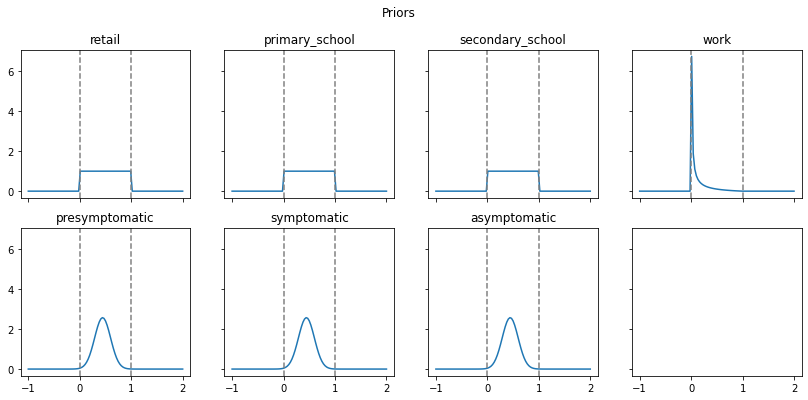

In [28]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = ( pyabc.RV("norm", 0.444, 0.155)  for _ in range(3)  )

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail":retail_rv, "primary_school": primary_school_rv, "secondary_school":secondary_school_rv, "work":work_rv,
    "presymptomatic":presymptomatic_rv, "symptomatic":symptomatic_rv, "asymptomatic":asymptomatic_rv    
}
    

fig, axes = plt.subplots(2, 4, figsize=(14,6), sharex=True, sharey=True)
x = np.linspace(-1,2,99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*')) 
for i, (var_name, variable) in enumerate(all_rv.items()):
    #var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

#ax.legend()
#fig.tight_layout()
fig.suptitle("Priors")

This code, not used, crates a random variable for the initial case estimates, per MSOA, at the start of the window. 
Assume they follow an exponential distribution, so the parameter we are actually trying to estimate is the $\lambda$ for each area. Assume that most areas start with almost no cases, so $\lambda>1$.

#### Prior distribution

Create a distrubtion from these random variables 

In [29]:
# Decorate all priors so that they don't go below 0 (doesn't make sense to have negative multipliers).
# (This is unnecessary for the uniform RVs, but doesn't hurt)
decorated_rvs = { name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items() }

# The distribution is a collection of the priors and their name (e.g. 'asymptomatic'=asymptomatic_rv, 'work'=work_rv, .. )
# so can just unpack the decorated_rvs dictionary and pass it straight in
priors = pyabc.Distribution(**decorated_rvs)
priors

<Distribution
    retail=[Lower: X > 0.000000]<RV name=uniform, args=(0, 1), kwargs={}>,
    primary_school=[Lower: X > 0.000000]<RV name=uniform, args=(0, 1), kwargs={}>,
    secondary_school=[Lower: X > 0.000000]<RV name=uniform, args=(0, 1), kwargs={}>,
    work=[Lower: X > 0.000000]<RV name=beta, args=(0.1, 2), kwargs={}>,
    presymptomatic=[Lower: X > 0.000000]<RV name=norm, args=(0.444, 0.155), kwargs={}>,
    symptomatic=[Lower: X > 0.000000]<RV name=norm, args=(0.444, 0.155), kwargs={}>,
    asymptomatic=[Lower: X > 0.000000]<RV name=norm, args=(0.444, 0.155), kwargs={}>>

### Model 'template'

Constants and random variables need to be handed differentky. To set constants, create an instance of `OpenCLWrapper`; this is a 'template' instance of the model. Then ABC calls that instance directly via the `__call__` function, which allows random variables to be passed. I followed the suggestions from here: https://github.com/ICB-DCM/pyABC/issues/446 

In [32]:
parameters_file = os.path.join("../../", "model_parameters/", "default.yml")  # Need to tell it where the default parameters are

da_window_size = 14 # Set the size of a data assimilation window in days:

admin_params = { "quiet":True, "use_gpu": False, "store_detailed_counts": True, "start_day": 0, "run_length": da_window_size,
                "current_particle_pop_df": None, 
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR
               }

template = OpenCLWrapper(const_params_dict, **admin_params)

# Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
template.__name__ = OpenCLWrapper.__name__

print(f"Created a template model with: \n\tconstant params: {const_params_dict}\n\tadmin params:{admin_params}")

Created a template model with: 
	constant params: {'current_risk_beta': 0.03, 'home': 1.0}
	admin params:{'quiet': True, 'use_gpu': False, 'store_detailed_counts': True, 'start_day': 0, 'run_length': 14, 'current_particle_pop_df': None, 'parameters_file': '../../model_parameters/default.yml', 'snapshot_file': '../../microsim/opencl/snapshots/cache.npz', 'opencl_dir': '../../microsim/opencl'}


/home/molly/RAMP-UA/microsim/opencl/ramp/params.py:58: UserWarning:

Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.



### First window

Run ABC for _w_ iterations with normal seeding

XXXX HERE: 
 - [X] Define the observations
 - [ ] Get the temporary ramp_da2.py file working
 - [ ] Try to run this notebook
 - [ ] Implement distance function

In [39]:
# Initialise:

abc = pyabc.ABCSMC(
    models=template, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
    distance_function=OpenCLWrapper.distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised anyway (and easier to debug)
    #sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
    #transition=transition,  # Define how to transition from one population to the next
    )

# Observations are cases per msoa, but make it into a numpy array because this may be more efficient
# (first axis is the msoa number, second is the day)
observations = cases_msoa.iloc[:,0:405].to_numpy()

db_path = ("sqlite:///" + "ramp_da2.db")
run_id = abc.new(db_path, {'observation': observations})

ABC.History INFO: Start <ABCSMC id=7, start_time=2021-11-03 11:49:47>


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 19 19 19 19 19 19 19  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14 14 15 15 15
 15 15 24 24 24 24 24 24 24 30 30 30 30 30 30 29 35 35 34 34 33 32 31  0
  0  0  0  0  0  0 35 35 35 36 36 37 38 37 38 39 40 41 41 42  0  0  0  0
  0  0  0 47 49 51 53 54 56 58 37 38 40 40 40 40 40 73 73 74 73 71 70 69
 41 40 40 40 39 39 39 36 36 36 35 34 33 33 34 33 32

In [ ]:
# Run :

history = abc.run(max_nr_populations=2)

print(f"Running new ABC with id {run_id}.... ", flush=True)

Algorithm diagnostics

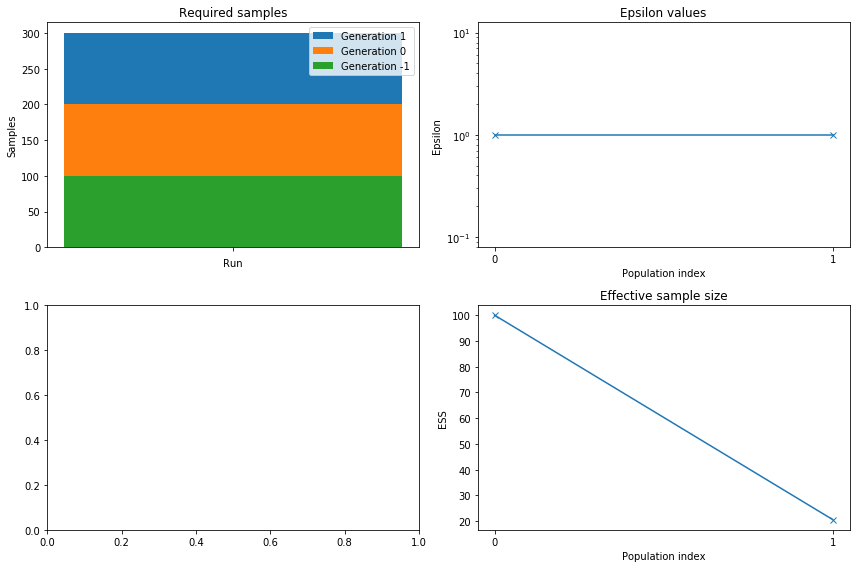

In [15]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

In [48]:
abc_output = history.get_weighted_sum_stats_for_model()
assert len(abc_output[0]) ==  len(abc_output[1])

In [86]:
# Get a snapshot
snap = x[1][1]['simulator'].item()
snap

In [87]:
# Check the mean status of people
snap.buffers.people_statuses.mean()

0.0016812668899726596


In [88]:
# Use it to create a simulator
from microsim.opencl.ramp.simulator import Simulator

sim = Simulator(snap, opencl_dir=OPENCL_DIR, gpu=False)
sim

/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning:

Params object is being created using hard-coded default values, not those in the parameters file.



In [89]:
# Upload the snapshot to the simulator
sim.upload_all(snap.buffers)

In [90]:
# Doanload the snapsopt from the simulator
sim.download("people_statuses", snap.buffers.people_statuses)

In [91]:
# Should be same as before
snap.buffers.people_statuses.mean()

0.0016812668899726596

In [150]:
# Lets see how many people of different disease states are in each of those simulations
# (can't plot full summary because we don't record the statuses at every iteration, but we could do)
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

def disease_count(sims):
    """Return a dictionary of {disease_status: [count1, count2, ..., countN]}
    where countX is the number of people with that disease status in model N"""
    d = dict()
    for status in DiseaseStatus:
        disease_counts = []
        for sim in sims:
            # Count the number of people who have this status (by filtering using np.where)
            disease_counts.append(len(
                sim.buffers.people_statuses[np.where( sim.buffers.people_statuses == status.value)]))
        d[status.name] = disease_counts
    return d

disease_statuses = [status for status in DiseaseStatus]
simulators = [abc_output[1][i]['simulator'].item() for i in range(len(abc_output[1]))]
                        
disease_counts = pd.DataFrame(
    data= { 
        "Particle": [i for i in range(len(abc_output[0]))],
        "Weight":  [ abc_output[0][i] for i in range(len(abc_output[0]))],
        **disease_count(simulators)
    }
)
disease_counts

,Particle,Weight,Susceptible,Exposed,Presymptomatic,Asymptomatic,Symptomatic,Recovered,Dead
0,0,0.047156,656371,0,0,0,0,0,0
1,1,0.034008,694794,249,20,158,35,52,1
2,2,0.010963,694735,271,23,177,45,58,0
3,3,0.001114,694931,125,22,122,53,56,0
4,4,0.002723,694908,133,18,143,51,56,0
...,...,...,...,...,...,...,...,...,...
95,95,0.000688,694591,366,31,206,58,57,0
96,96,0.135337,694892,166,14,145,41,51,0
97,97,0.004577,693745,841,107,451,107,58,0
98,98,0.002139,694363,435,56,325,72,58,0


In [151]:
#XXXX HERE PLOT THE COUNTS and then start the next window


XXXX HERE

TODO:

 - [ ] make a summary diagram for Jon and arrange a meeting
 
 - implement __call__ : runs a model
   - [ ] ** needs to be able to draw new models from the posterior (df) ** - easiest way is to include all disease statuses as random parameters?? Ask Jon about this.
   - [ ] needs to return model state in a dictionary
 - [ ] implement summary_stats()
 - [ ] implement distance()
 - 

In [ ]:
### Remaining windows 

XXXX

### Run the model for N iterations, stop, then continue.

_Basically as a test_

In [ ]:


from tqdm import tqdm

Run the model for 5 iterations, stop, then continue

In [40]:
QUIET=True
USE_GPU = False
STORE_DETAILED_COUNTS = True
ITERATIONS = 5 # Run for 5 iterations each time
iter_count = 0  # Count the total number of iterations
sim_number=0

# load snapshot
snapshot = Snapshot.load_full_snapshot(path=SNAPSHOT_FILEPATH)

# set params
snapshot.update_params(PARAMS)

# set the random seed of the model for each repetition, otherwise it is completely deterministic
snapshot.seed_prngs(sim_number)

# Create a simulator and upload the snapshot data to the OpenCL device
# XXXX CAN PASS num_seed_days=0 ! 
simulator = Simulator(snapshot, opencl_dir=OPENCL_DIR, gpu=USE_GPU)
simulator.upload_all(snapshot.buffers)

if not QUIET: 
  print(f"Running simulation {sim_number + 1}.")

params = Params.fromarray(snapshot.buffers.params)  # XX Why extract Params? Can't just use PARAMS?

summary = Summary(snapshot, store_detailed_counts=STORE_DETAILED_COUNTS, 
                  max_time=20  # Total length of the simulation
                 )

# only show progress bar in quiet mode
timestep_iterator = range(ITERATIONS) if QUIET else tqdm(range(ITERATIONS), desc="Running simulation")

# Run for iterations days

for _ in timestep_iterator:
    # XX Ask Rory to go through exactly what is happenning here re. uploading and downloading and
    # where the model state is stored.
    # And how the seeding takes place in the Snapshot
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)

if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)
        
# Run for another ITERATIONS days

for _ in timestep_iterator:
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)



if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)

if not QUIET:
    print("\nFinished")

# Sanity check. The opencl buffers should be the same length as the individuals data frame.
assert len(individuals) == len(snapshot.buffers.people_statuses)

# Download the snapshot from OpenCL to host memory
# XX This is 'None'.
final_state = simulator.download_all(snapshot.buffers)

NameError: name 'Snapshot' is not defined

### See what happened

#### Total number of infections

In [ ]:
# Lets see what happened: 
fig, ax = plt.subplots(1, 1, figsize=(10,7))
plot_type = "error_bars"
reps=1  # Number of repetitions (1 so far)
iters=len(summary.total_counts[0])  # Total number of iterations
x = range(iters)

for d, disease_status in enumerate(DiseaseStatus):
    if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
        continue
    # Calculate the mean and standard deviation
    matrix = np.zeros(shape=(reps,iters))
    if reps==1:  # Only one repetition means a 1-D matrix
        matrix[reps-1] = summary.total_counts[d]
    else:  # Otherwise we ran a load of models, so want to plot lots of summaries
        for rep in range(reps):
            matrix[rep-1] = summaries[rep].total_counts[d]
    mean = np.mean(matrix, axis=0)
    sd = np.std(matrix, axis=0)
    if plot_type == "error_bars":
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
    elif plot_type == "lines":
        for rep in range(reps):
            ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                    color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

# Add observation data (subtract 1 because first day is called day '1' but sim starts at 0)
ax.plot(gam_cases.loc[0:iters-1, 'Day']-1, gam_cases.loc[0:iters-1, 'Cases'], '--', color="black", label="Daily Cases")
                
ax.legend() 
ax.set_title("Disease Status")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of cases")

Check that we can map the diseases (for info)

#### Disease state of individuals

Now find (and later manipulate) the state of the model

_Note: to find out which fields are available in the OpenCL model buffers, do:_
```
print(snapshot.buffers._fields)
```

In [ ]:
print(snapshot.buffers._fields)

# Infected individuals

# 'assign' adds a new column called 'Status' which is the numeric status value from the OpenCl buffer, but
# converted into a descriptive disease status by 'map'. ('list' forces map to do the calculation, otherwise it is lazy)
individuals = individuals.assign(Status=list(map(DiseaseStatus, snapshot.buffers.people_statuses)))

# Filter the dataframe on status>0 to get infected individuals
infected_individuals = individuals.loc[snapshot.buffers.people_statuses>0]
print(f"There are {len(infected_individuals)} with disease status > 0")

#### Diseases by area

In [ ]:
# XX Ask Rory how 'place' is stored in the OpenCL buffers. E.g. does it keep track of MSOA?
# (below we get the MSOA code from the original individuals file)

# Create a dataframe of infected areas (those with any individual with a non-zero disease status).
# (The as_type() converts from a category to avoid areas with 0 counts being included)
infected_areas = infected_individuals.astype({'area': 'str'}).area.value_counts().to_frame('TotalDisease')
# Now add columns for the different disease statuses
for d in DiseaseStatus:
    right_df = individuals.loc[snapshot.buffers.people_statuses==d.value].area.value_counts().to_frame(d)
    infected_areas = infected_areas.merge(right=right_df, left_index=True, right_index=True)

del right_df
infected_areas

### Manipulate state, then keep running 

_Another test_. Will remove all pre-symptomatic infections and see what happens to the disease

In [41]:
# Get the current statuses
simulator.download("people_statuses", snapshot.buffers.people_statuses)

# Remove all exposed, pre-symptomatic, and asymptomatic (set all statuses from 1,2 or 3 to zero, otherwise keep as they are)
f = np.vectorize(lambda x: x if x < 1 or x > 3 else 0)  # (vectorise needed so that the function can be applied to each element)
snapshot.buffers.people_statuses[:] = f(snapshot.buffers.people_statuses)

# Remove all disease (not just pre-symptomatic)
#snapshot.buffers.people_statuses[:] = 0

# Upload the new statuses
simulator.upload_all(snapshot.buffers)
# simulator.upload("people_statuses", f(snapshot.buffers.people_statuses[:]) # (can be used to update just one buffer?)

# Run for a further x days
for _ in range(10):
    # Update parameters based on lockdown
    params.set_lockdown_multiplier(snapshot.lockdown_multipliers, iter_count)
    simulator.upload("params", params.asarray())

    # Step the simulator
    simulator.step()
    iter_count += 1

    # Update the statuses stored in the summary
    simulator.download("people_statuses", snapshot.buffers.people_statuses)
    summary.update(iter_count, snapshot.buffers.people_statuses)
    

if not QUIET:
    for i in range(ITERATIONS):
         print(f"\nDay {i}")
         summary.print_counts(i)

if not QUIET:
    print("\nFinished")

# Sanity check. The opencl buffers should be the same length as the individuals data frame.
assert len(individuals) == len(snapshot.buffers.people_statuses)

NameError: name 'simulator' is not defined

In [ ]:
# Lets see what happened: 
fig, ax = plt.subplots(1, 1, figsize=(10,7))
plot_type = "error_bars"
reps=1  # Number of repetitions (1 so far)
iters=len(summary.total_counts[0])  # Total number of iterations
x = range(iters)

for d, disease_status in enumerate(DiseaseStatus):
    if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
        continue
    # Calculate the mean and standard deviation
    matrix = np.zeros(shape=(reps,iters))
    if reps==1:  # Only one repetition means a 1-D matrix
        matrix[reps-1] = summary.total_counts[d]
    else:  # Otherwise we ran a load of models, so want to plot lots of summaries
        for rep in range(reps):
            matrix[rep-1] = summaries[rep].total_counts[d]
    mean = np.mean(matrix, axis=0)
    sd = np.std(matrix, axis=0)
    if plot_type == "error_bars":
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
    elif plot_type == "lines":
        for rep in range(reps):
            ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                    color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

# Add observation data (subtract 1 because first day is called day '1' but sim starts at 0)
ax.plot(gam_cases.loc[0:iters-1, 'Day']-1, gam_cases.loc[0:iters-1, 'Cases'], '--', color="black", label="Daily Cases")
                
ax.legend() 
ax.set_title("Disease Status")
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of cases")

### Distance function

Need to calculate how well the model is doing on a particular day by comparing the locations of current cases to those in the real case data


In [ ]:
# Simulated infections.

# Number of presymptomatic and asymptomatic people per MSOA
cases_per_msoa = individuals.loc[(snapshot.buffers.people_statuses==DiseaseStatus.Presymptomatic.value) | 
                                     (snapshot.buffers.people_statuses==DiseaseStatus.Asymptomatic.value)].area.value_counts().to_frame('CasesSim')
for status, col_name in [ (DiseaseStatus.Presymptomatic.value, "CasesSympSim" ), (DiseaseStatus.Asymptomatic.value, "CasesASympSim") ]:
    cases_per_msoa[col_name] = cases_per_msoa.join(other=individuals.loc[(snapshot.buffers.people_statuses==status)].area.value_counts().to_frame(col_name))[col_name]

# Observed cases (add these to the DF above)
day = iter_count
col = 'D'+str(day-1)  # Name of the column with this day's data

cases_per_msoa['CasesObs'] = cases_per_msoa.join(other=cases_msoa.loc[:,col].to_frame('CasesObs'))['CasesObs']
# Need to estimate how many of these are (pre)symptomatic and asymptomatic
symptomatic_proportion = 0.8
cases_per_msoa['CasesSympObs'] = cases_per_msoa.CasesObs * symptomatic_proportion
cases_per_msoa['CasesASympObs'] = cases_per_msoa.CasesObs * (1-symptomatic_proportion)

In [ ]:
def distance(sim, obs):
    """Calculate the distance between the number of cases in the model by MSOA compared to some observations (case data).
    All lists are assumed to be in the same MSOA order (e.g. first element in each list corresponds to the number of cases
    in the same MSOA).
    
    :param sim: Case data per MSOA. A dictionary with two lists: 
      - Symp (number of presymptomatic people in each MSOA in the current day
      - Asymp (number of asymptomatic people in each MSOA in the current day)
    :param obs: Same as `sim`, but have lists have the number of (pre)symptomatic people from real case data
    """
    # For now just do the sum of euclidean distances between presymptomatic and symptomatic cases.
    
    # Check all lists are the same length
    if not ( len(sim['Symp']) == len(sim['Asymp']) == len(obs['Symp']) == len(obs['Asymp']) ):
        raise Exception(f"Lengths should be the same")
    
    symp_difference = np.linalg.norm(np.array(obs['Symp']) - np.array(sim['Symp']))
    pres_difference = np.linalg.norm(np.array(obs['Asymp']) - np.array(sim['Asymp']))
    print(symp_difference, pres_difference)
        
    return symp_difference + pres_difference

# Test it
distance({'Symp': cases_per_msoa['CasesSympSim'], 'Asymp': cases_per_msoa['CasesASympSim']},  # Sim data
         {'Symp': cases_per_msoa['CasesSympObs'], 'Asymp': cases_per_msoa['CasesASympObs']}   # Obs data
        )

## Data Assimilation with the RAMP model

Now that we have all the components, use ABC to do DA on the ramp model.

In [ ]:
XXXX HERE

In [ ]:
## OLD CODE

In [ ]:
ITERATIONS = 100  # Number of iterations to run for

STORE_DETAILED_COUNTS = False
REPETITIONS = 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

In [ ]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()

### Plot output summary data

#### Total counts of disease status

In [ ]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

In [ ]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [ ]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

In [ ]:
plot_disease_status_by_age(summaries0)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Fitness

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [ ]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

In [ ]:
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0, "current_risk_beta": 0.03, "presymptomatic": 1.0, "symptomatic": 1.0 })
# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
#home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([1], [1.0])) for _ in range(2) )

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook). 
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75] 
asymptomatic_rv = pyabc.RV("norm", 0.444, 0.155)

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True)
x = np.linspace(0,2,49)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*')) 
for i, variable in enumerate([retail_rv, primary_school_rv, secondary_school_rv, work_rv,
                 asymptomatic_rv]):
    var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

#ax.legend()
fig.suptitle("Priors")
fig.tight_layout()


In [ ]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    #presymptomatic = presymptomatic_rv,
    #symptomatic = symptomatic_rv, 
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    #current_risk_beta = current_risk_beta_rv
    )

(Optionally) define the transitions. The transitions ('perturbation kernels') define how the current population is transitioned to the next one. The default (multivariate normal) transition doesn't work for discrete values, so  we need a separate transition for the static parameters.

_Note: I experimented with this as a way to hack a constant variable by using a `DiscreteJumpTransition`, but it didn't work because the domain of transition was necessarily a single number (1) but the transition complained that it had nowhere to go_

### Initialise the ABC algorithm.

In [ ]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
    )

Define observations

In [ ]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [ ]:
db_path = ("sqlite:///" + os.path.join(".", "abc-2.db"))

In [ ]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

### Run ABC

In [ ]:
history = None
fname = "./abc-2.pkl"

if LOAD_PICKLES and os.path.isfile(fname):
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    history = abc.run(max_nr_populations=2) 
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

### Algorithm diagnostics

In [ ]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

In [ ]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [ ]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

In [ ]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [ ]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [ ]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}
    
    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")
    
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Plot the individual results for each sample

In [ ]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness-min(_fitness))/(max(_fitness)-min(_fitness))

fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            #label=f"Particle {df.index[sample_idx[i]]}", 
            color="black", alpha = 1-fitness_norm[i]  # (1-x because high fitness is bad)
    )
    
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

del _fitness, fitness_norm

Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

In [ ]:
best_paramswo long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-100) for each particle
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');

Do a KDE plot with a logarithmic colour scale.

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1, figsize=(10,7))

h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5),
         norm=LogNorm())

ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [ ]:
# Load samples if needed
#fitness_l, sim_l, obs_l, out_params_l, summaries_l = pickle_samples("load")

# Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
best_params

See how those parameters relate to the marginal posteriors

In [ ]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

In [ ]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0", color="orange")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1", color="red")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1)]: 
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

Run the model with arbitray parameters (to experiment)

In [ ]:
best_params

In [ ]:
#OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness2, sim2, obs2, out_params2, summaries2) = OpenCLRunner.run_model_with_params_abc(
    {'retail': 0.9,
     'primary_school': 0.9,
     'secondary_school': 0.9,
     'work': 0.00001,
     'asymptomatic': 0.124},
    return_full_details=True)
#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0 (initial)", color="orange")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1 (optimised)", color="red")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries2), label="sim2 (new)", color="black")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1), (summaries2, fitness2) ]: 
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

In [ ]:
N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 